diabates 당뇨병 분류를 CNN으로 구현하고
모델을 저장한 후에
사전학습 모델로 불러서 추가적인 층 및 출력층 추가하고
미세조정 fine-tunning 

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

df = pd.read_csv("datas/diabetes.csv")
df

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-10-24 00:01:04.009277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Text(0.5, 1.0, 'Label')

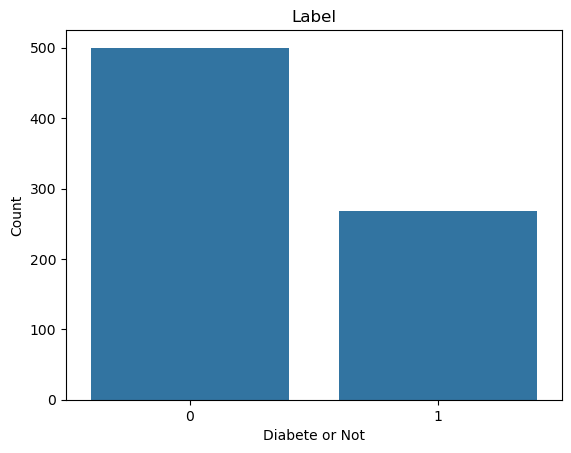

In [6]:
sns.countplot(data = df, x="Outcome")
plt.xlabel("Diabete or Not")
plt.ylabel("Count")
plt.title("Label")

In [7]:
df_majority = df[df['Outcome'] == 0]
df_minority = df[df['Outcome'] == 1]

df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

df = pd.concat([df_majority_downsampled, df_minority])
df['Outcome'].value_counts()

Outcome
0    268
1    268
Name: count, dtype: int64

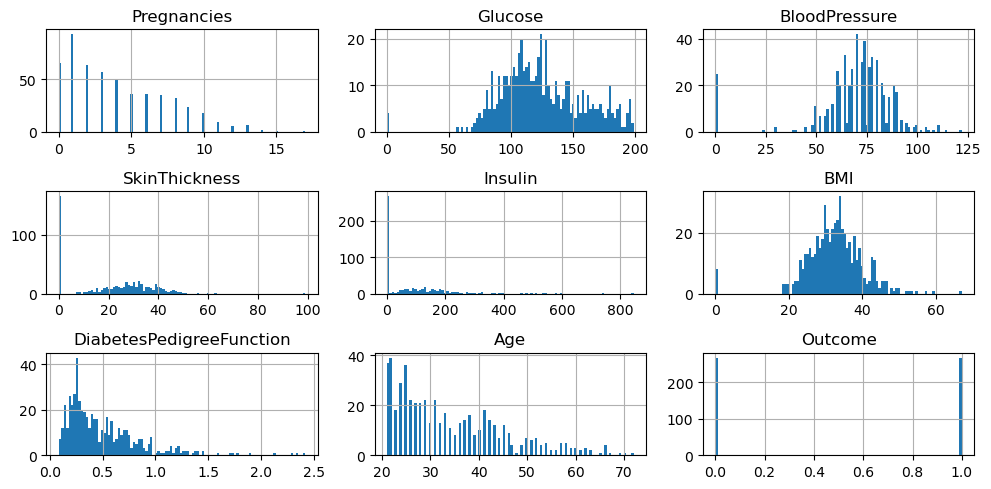

In [8]:
df.hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [9]:
correlation_matrix = df.corr()
print(correlation_matrix)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.115253       0.114106      -0.093456   
Glucose                      0.115253  1.000000       0.128715       0.053073   
BloodPressure                0.114106  0.128715       1.000000       0.190621   
SkinThickness               -0.093456  0.053073       0.190621       1.000000   
Insulin                     -0.033224  0.325281       0.086800       0.448939   
BMI                          0.005954  0.197743       0.244144       0.366816   
DiabetesPedigreeFunction    -0.057325  0.125992       0.040177       0.208554   
Age                          0.512950  0.292035       0.238305      -0.095770   
Outcome                      0.219760  0.488653       0.074021       0.097215   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.033224  0.005954                 -0.057325   
Glucose                   0.325281  0.197

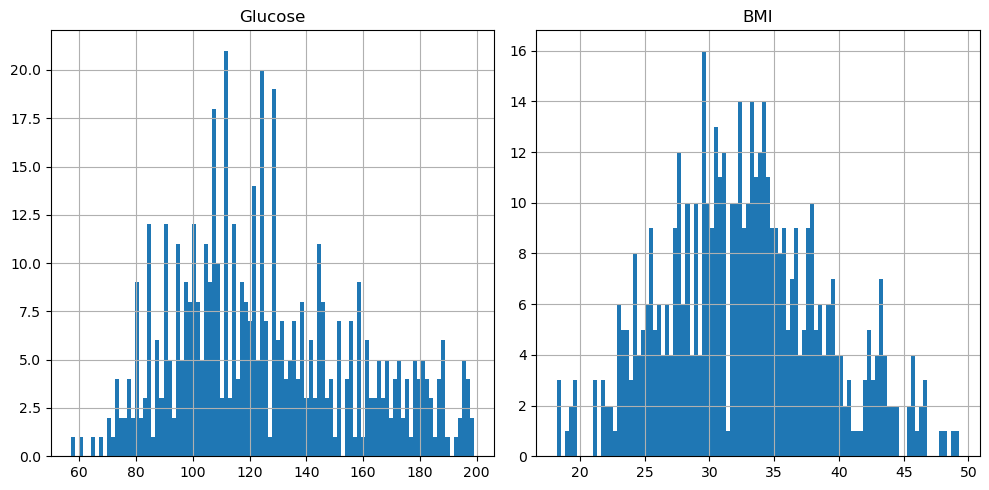

In [10]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]
    return df
columns_to_check = ['Glucose', 'BMI']
df = remove_outliers(df, columns_to_check)

df[columns_to_check].hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [11]:
(df == 0).sum()
# Glucose와 BMI는 0개 이므로 채울 필요 없음.

Pregnancies                  59
Glucose                       0
BloodPressure                19
SkinThickness               158
Insulin                     255
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     259
dtype: int64

/opt/anaconda3/envs/deep-learning/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


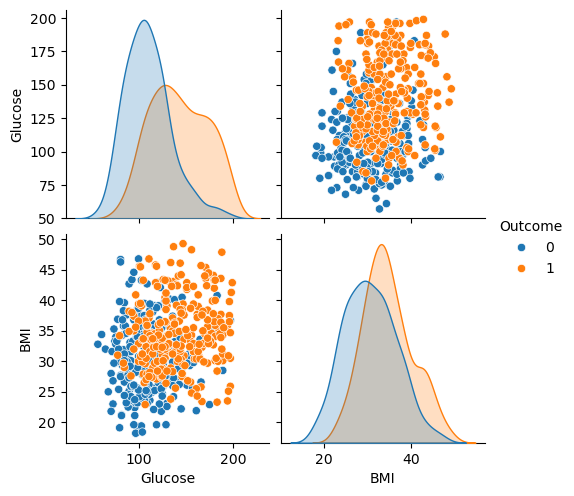

In [12]:
sns.pairplot(df,
             vars=columns_to_check,
            hue ='Outcome')
plt.show()

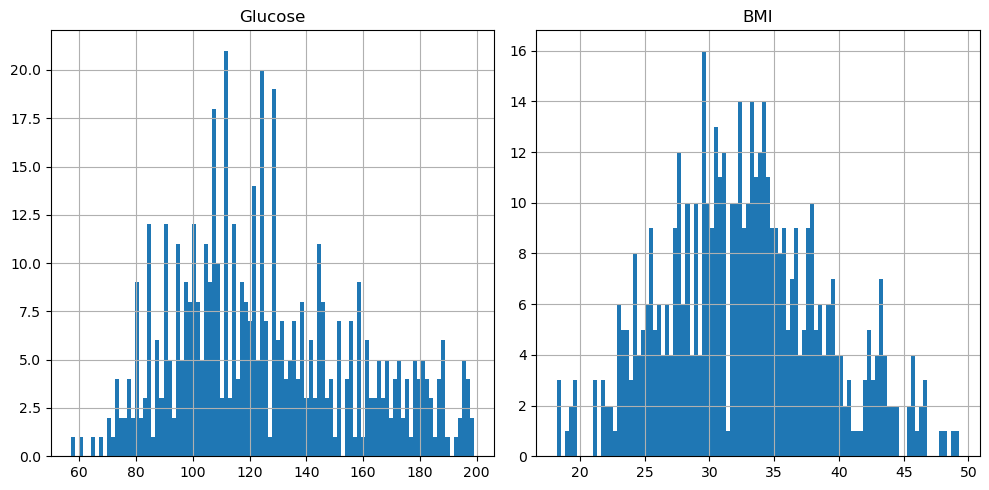

In [13]:
X = df[columns_to_check]
X.hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [14]:
from tensorflow.keras.utils import to_categorical
y = df['Outcome']
y = to_categorical(y) 
y


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape) 
print(y_train.shape) 


(411, 2, 1)
(411, 2)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model_cnn = Sequential()
model_cnn.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(2, activation='sigmoid')) 
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
print(f"테스트 손실: {test_loss}, 테스트 정확도: {test_accuracy}")

Epoch 1/10
11/11 [==============================] - 3s 51ms/step - loss: 0.6876 - accuracy: 0.5488 - val_loss: 0.6798 - val_accuracy: 0.6145
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5671 - val_loss: 0.6694 - val_accuracy: 0.6145
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.6748 - accuracy: 0.5854 - val_loss: 0.6584 - val_accuracy: 0.6867
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6684 - accuracy: 0.6067 - val_loss: 0.6493 - val_accuracy: 0.7108
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.6605 - accuracy: 0.6067 - val_loss: 0.6386 - val_accuracy: 0.6627
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.6542 - accuracy: 0.6220 - val_loss: 0.6287 - val_accuracy: 0.6627
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.6189 - val_loss: 0.6203 - val_accuracy: 0.6627
Epoch 8/10
11/11 [=

In [23]:
model_file='datas/diabetes.h5'
tf.keras.models.save_model(model_cnn, model_file, include_optimizer=False)

In [24]:
from tensorflow.keras.models import load_model
base_model = load_model(model_file)

In [25]:
for layer in base_model.layers:
    layer.trainable = False 

In [26]:
model_cnn.add(Dense(64, activation='relu')) 
model_cnn.add(Dense(2, activation='softmax')) 
# 이진이라 sigmoid
# 다중이면 softmax

In [27]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
13/13 [==============================] - 1s 40ms/step - loss: 0.6960 - accuracy: 0.4866 - val_loss: 0.6897 - val_accuracy: 0.5728
Epoch 2/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6910 - accuracy: 0.5742 - val_loss: 0.6875 - val_accuracy: 0.6990
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6882 - accuracy: 0.6545 - val_loss: 0.6839 - val_accuracy: 0.7767
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.6983 - val_loss: 0.6793 - val_accuracy: 0.7379
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6792 - accuracy: 0.7275 - val_loss: 0.6729 - val_accuracy: 0.7379
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.7178 - val_loss: 0.6618 - val_accuracy: 0.7670
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6614 - accuracy: 0.7153 - val_loss: 0.6496 - val_accuracy: 0.7379
Epoch 8/50
13/13 [

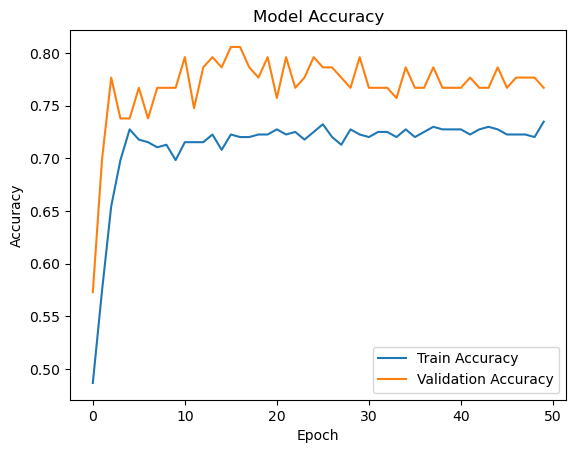

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

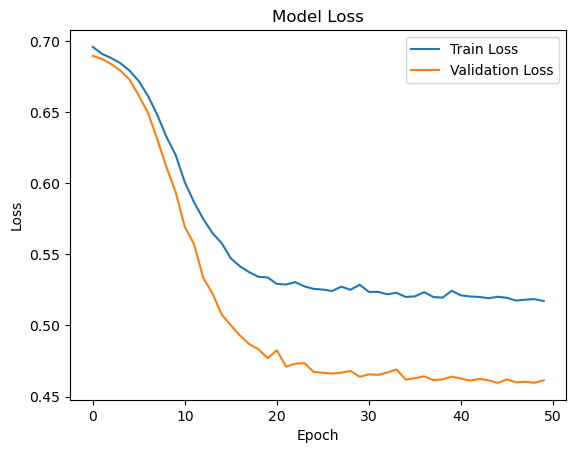

In [29]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()